# Usage examples

In [1]:
# Standard and third party modules
import os
import sys
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry.polygon import Polygon
from matplotlib.colors import ListedColormap

# GeoVille Storage Gate
sys.path.append("../..")
from geoville_storage_gate.vector import *

## Vector

One part of the GeoVille Storage Gate handles the reading and writing of vector data.  
Let's read an example vector file with some polygons first.

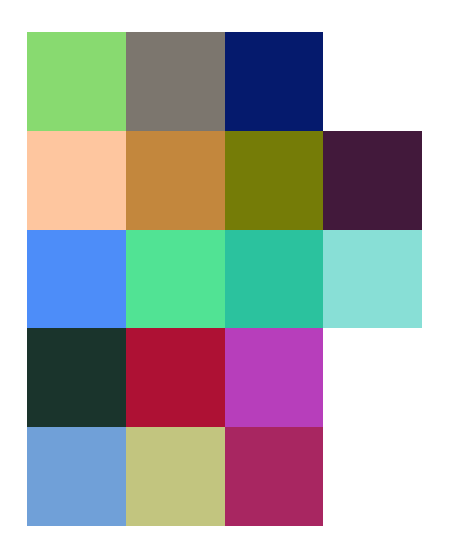

In [2]:
test_vector_path = "/home/schmid/Repos/geoville_ms_storage_gate_modul/tests/data/test_vector.shp"
test_vector_geodataframe = gpd.read_file(test_vector_path)

cmap = cmap = ListedColormap(np.random.rand(256,3))
ax = test_vector_geodataframe.plot(column='TileID', 
                                   cmap=cmap, 
                                   figsize=(10, 10))
ax.set_axis_off()

Now that we have an example vector dataset, let's create a netCDF file and write that data into it.

In [3]:
ncdf_output_path = "/home/schmid/Desktop/vector_example.nc"

if os.path.exists(ncdf_output_path):
    os.remove(ncdf_output_path)

First we need to use ``create_by_group``, because the netCDF file does not exist yet.  
We need to provide the geodataframe, the netCDF output path, the name of the group which will be created and in which the vector will lie as well as a dictionary with metadata. The metadata needs to contain the correct Coordinate Reference System (CRS).

In [4]:
create_by_group(test_vector_geodataframe, 
                 ncdf_output_path, 
                 "test_vector_group",
                 {"crs": test_vector_geodataframe.crs})

Now that we created a netCDF file with an initial group, we can also read out that group into a geodataframe.

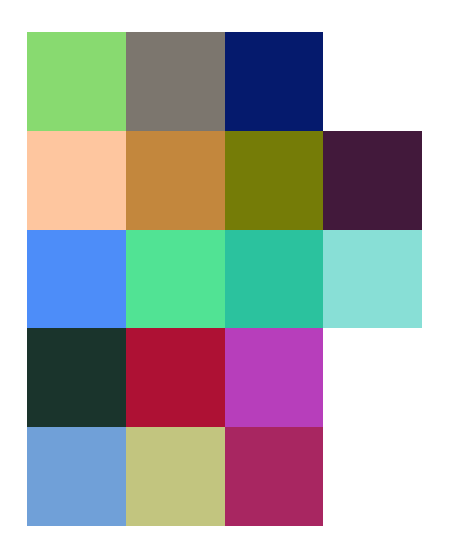

In [5]:
created_geodataframe = read_by_group(ncdf_output_path,
                                     "test_vector_group")

ax = created_geodataframe.plot(column='TileID', 
                               cmap=cmap, 
                               figsize=(10, 10))
ax.set_axis_off()

So now we want to update features that meet certain criteria using a query.  
The function ``update_by_attribute`` does that by taking a look at all existing groups within the given netCDF file.  
In the following example, we update all features who's 'TileID' equals 'E09N54' with an empty geometry.
Features within netCDF files cannot be deleted, so we do so by updating the geometry with an empty one.
A cleaning job, that will be run once in a while, will get rid of empty geometries.

In [6]:
update_by_attribute(ncdf_output_path, 
                    'TileID', 
                    "E09N54", 
                    'geometry', 
                    wkt.dumps(Polygon([])), 
                    query='=')

Let's read the entire netCDF group again!

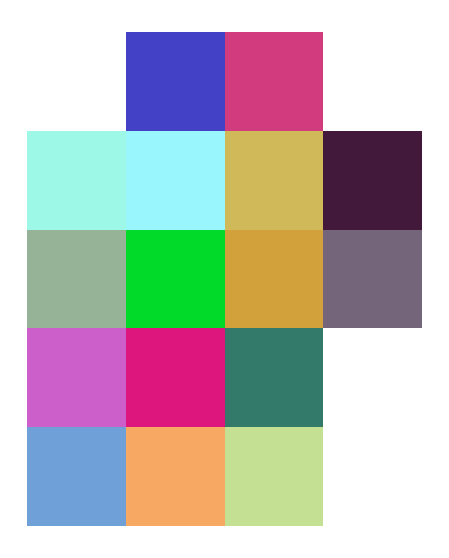

In [7]:
created_geodataframe = read_by_group(ncdf_output_path,
                                     "test_vector_group")

ax = created_geodataframe.plot(column='TileID', 
                               cmap=cmap, 
                               figsize=(10, 10))
ax.set_axis_off()

We see that the top left polygon disappeared.  
Moreover, when reading the attribute table of the updated dataset, the empty geometry is not visible anymore.

In [8]:
created_geodataframe

left       top     right    bottom  TileID  \
1    98900.0  547300.0  188900.0  457300.0  E09N45   
2    98900.0  457300.0  188900.0  367300.0  E09N36   
3    98900.0  367300.0  188900.0  277300.0  E09N27   
4    98900.0  277300.0  188900.0  187300.0  E09N18   
5   188900.0  637300.0  278900.0  547300.0  E18N54   
6   188900.0  547300.0  278900.0  457300.0  E18N45   
7   188900.0  457300.0  278900.0  367300.0  E18N36   
8   188900.0  367300.0  278900.0  277300.0  E18N27   
9   188900.0  277300.0  278900.0  187300.0  E18N18   
10  278900.0  637300.0  368900.0  547300.0  E27N54   
11  278900.0  547300.0  368900.0  457300.0  E27N45   
12  278900.0  457300.0  368900.0  367300.0  E27N36   
13  278900.0  367300.0  368900.0  277300.0  E27N27   
14  278900.0  277300.0  368900.0  187300.0  E27N18   
15  368900.0  547300.0  458900.0  457300.0  E36N45   
16  368900.0  457300.0  458900.0  367300.0  E36N36   

                                             geometry  
1   POLYGON ((98900.000 547300.000, 188900.000 547...  
2   POLYGON ((98900.000 457300.000, 188900.000 457...  
3   POLYGON ((98900.000 367300.000, 188900.000 367...  
4   POLYGON ((98900.000 277300.000, 188900.000 277...  
5   POLYGON ((188900.000 637300.000, 278900.000 63...  
6   POLYGON ((188900.000 547300.000, 278900.000 54...  
7   POLYGON ((188900.000 457300.000, 278900.000 45...  
8   POLYGON ((188900.000 367300.000, 278900.000 36...  
9   POLYGON ((188900.000 277300.000, 278900.000 27...  
10  POLYGON ((278900.000 637300.000, 368900.000 63...  
11  POLYGON ((278900.000 547300.000, 368900.000 54...  
12  POLYGON ((278900.000 457300.000, 368900.000 45...  
13  POLYGON ((278900.000 367300.000, 368900.000 36...  
14  POLYGON ((278900.000 277300.000, 368900.000 27...  
15  POLYGON ((368900.000 547300.000, 458900.000 54...  
16  POLYGON ((368900.000 457300.000, 458900.000 45...

Besides updating features using a query, we can also "upsert" the vector data within a netCDF file.  
Upserting is an operation that inserts features into a netCDF file if their geometry do not already exist, or updates them if they do.  
  
We will begin with ``upsert_by_bounds``. This function upserts all features of a given geodataframe that have a given relation to the provided boundary.  
In the following example, we update the netCDF file with the newly read update vector. All features of "update_geodataframe" will be written into "ncdf_output_path" that "intersect" the given bounds (shapely polygon).  
  
The function will upsert each netCDF group separately, in case the bounds intersects more than one group.
Hence, only the features that fall within the bounds and a group will be upserted to that group.

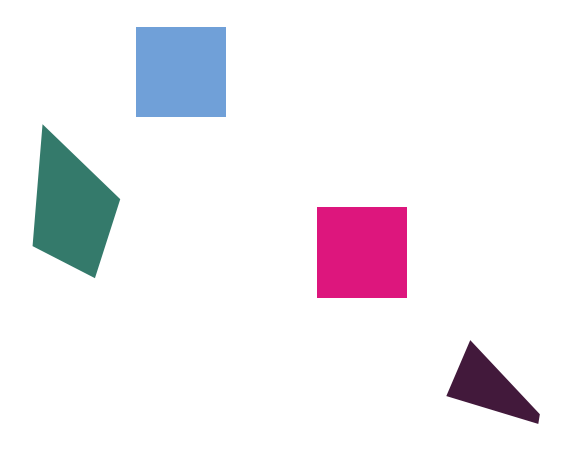

In [9]:
update_vector_path = "/home/schmid/Repos/geoville_ms_storage_gate_modul/tests/data/test_update_vector.shp"
update_geodataframe = gpd.read_file(update_vector_path)
ax = update_geodataframe.plot(column='TileID', 
                              cmap=cmap, 
                              figsize=(10, 10))
ax.set_axis_off()

In [10]:
update_geodataframe

left       top     right    bottom  TileID  FID  \
0   98900.0  637300.0  188900.0  547300.0  E09N54    1   
1  278900.0  457300.0  368900.0  367300.0  E27N36    2   
2       1.0       1.0       1.0       1.0       a    3   
3       2.0       2.0       2.0       2.0       b    4   

                                            geometry  
0  POLYGON ((98900.000 637300.000, 188900.000 637...  
1  POLYGON ((278900.000 457300.000, 368900.000 45...  
2  POLYGON ((6086.354 540089.272, 83425.287 46547...  
3  POLYGON ((431792.698 325173.217, 501062.580 25...

We see that two features of the update-geodataframe are similar to the original example geodataframe.  
However, we are only upserting those features that intersect the following boundary.

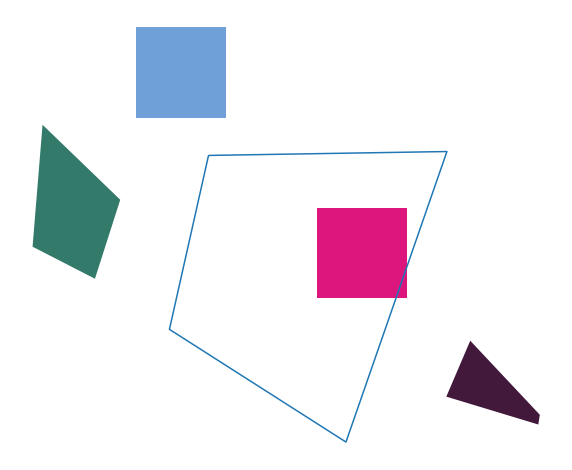

In [11]:
polygon_as_geodataframe = gpd.GeoDataFrame(gpd.GeoSeries(Polygon([[171294, 509586],
                                                                  [408599, 513476],
                                                                  [308101, 224301],
                                                                  [132392, 336470]])), columns=['geometry'])
f, ax = plt.subplots(figsize=(10, 10))
update_geodataframe.plot(column='TileID', 
                         cmap=cmap, 
                         figsize=(10, 10),
                         ax=ax)

polygon_as_geodataframe.boundary.plot(ax=ax)
ax.set_axis_off()

In [12]:
upsert_by_bounds(update_geodataframe, 
                 ncdf_output_path,
                 Polygon([[171294, 509586],
                          [408599, 513476],
                          [308101, 224301],
                          [132392, 336470]]), 
                 "intersects")

Due to the fact that the geometry of the only polygon we upsert already exists, the feature will get updated.  
We can simply check that by reading the netCDF group again and check the attribute table.  
The updated-geodataframe has the new column "FID".

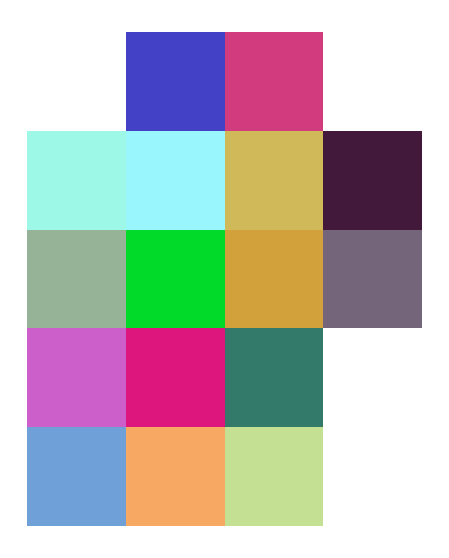

In [13]:
created_geodataframe = read_by_group(ncdf_output_path, 
                                     "test_vector_group")

ax = created_geodataframe.plot(column='TileID', 
                               cmap=cmap, 
                               figsize=(10, 10))
ax.set_axis_off()

In [14]:
created_geodataframe

left       top     right    bottom  TileID  \
1    98900.0  547300.0  188900.0  457300.0  E09N45   
2    98900.0  457300.0  188900.0  367300.0  E09N36   
3    98900.0  367300.0  188900.0  277300.0  E09N27   
4    98900.0  277300.0  188900.0  187300.0  E09N18   
5   188900.0  637300.0  278900.0  547300.0  E18N54   
6   188900.0  547300.0  278900.0  457300.0  E18N45   
7   188900.0  457300.0  278900.0  367300.0  E18N36   
8   188900.0  367300.0  278900.0  277300.0  E18N27   
9   188900.0  277300.0  278900.0  187300.0  E18N18   
10  278900.0  637300.0  368900.0  547300.0  E27N54   
11  278900.0  547300.0  368900.0  457300.0  E27N45   
12  278900.0  457300.0  368900.0  367300.0  E27N36   
13  278900.0  367300.0  368900.0  277300.0  E27N27   
14  278900.0  277300.0  368900.0  187300.0  E27N18   
15  368900.0  547300.0  458900.0  457300.0  E36N45   
16  368900.0  457300.0  458900.0  367300.0  E36N36   

                                             geometry                  FID  
1   POLYGON ((98900.000 547300.000, 188900.000 547... -9223372036854775806  
2   POLYGON ((98900.000 457300.000, 188900.000 457... -9223372036854775806  
3   POLYGON ((98900.000 367300.000, 188900.000 367... -9223372036854775806  
4   POLYGON ((98900.000 277300.000, 188900.000 277... -9223372036854775806  
5   POLYGON ((188900.000 637300.000, 278900.000 63... -9223372036854775806  
6   POLYGON ((188900.000 547300.000, 278900.000 54... -9223372036854775806  
7   POLYGON ((188900.000 457300.000, 278900.000 45... -9223372036854775806  
8   POLYGON ((188900.000 367300.000, 278900.000 36... -9223372036854775806  
9   POLYGON ((188900.000 277300.000, 278900.000 27... -9223372036854775806  
10  POLYGON ((278900.000 637300.000, 368900.000 63... -9223372036854775806  
11  POLYGON ((278900.000 547300.000, 368900.000 54... -9223372036854775806  
12  POLYGON ((278900.000 457300.000, 368900.000 45...                    2  
13  POLYGON ((278900.000 367300.000, 368900.000 36... -9223372036854775806  
14  POLYGON ((278900.000 277300.000, 368900.000 27... -9223372036854775806  
15  POLYGON ((368900.000 547300.000, 458900.000 54... -9223372036854775806  
16  POLYGON ((368900.000 457300.000, 458900.000 45... -9223372036854775806

We see that we still have 16 features after deleting one.  
However, feature number 12 updated, which we can see due to the new attribute "FID".

In [15]:
created_geodataframe[created_geodataframe["TileID"]=="E27N36"]

left       top     right    bottom  TileID  \
12  278900.0  457300.0  368900.0  367300.0  E27N36   

                                             geometry  FID  
12  POLYGON ((278900.000 457300.000, 368900.000 45...    2

In contrast to ``upsert_by_bounds``, the function ``upsert_by_geodataframe`` uses the entire input geodataframe instead of a subset of it.  
Thus, the parameter "bounds" is not required here.  
  
In the following example, we update the vector dataset within the netCDF file with the original geodataframe from the beginning.

In [16]:
upsert_by_geodataframe(test_vector_geodataframe, 
                       ncdf_output_path)

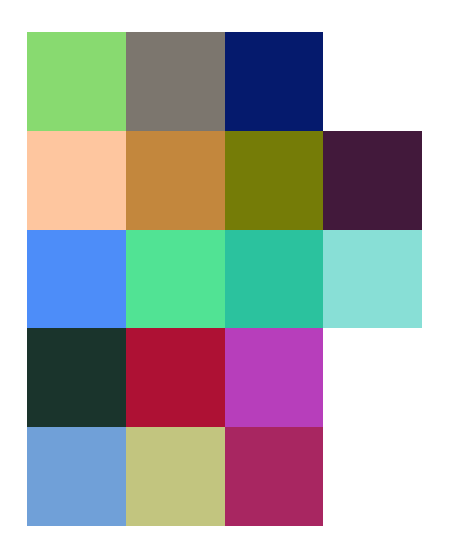

In [17]:
created_geodataframe = read_by_group(ncdf_output_path, 
                                     "test_vector_group")

ax = created_geodataframe.plot(column='TileID', 
                               cmap=cmap, 
                               figsize=(10, 10))
ax.set_axis_off()

In [18]:
created_geodataframe

left       top     right    bottom  TileID  \
1    98900.0  547300.0  188900.0  457300.0  E09N45   
2    98900.0  457300.0  188900.0  367300.0  E09N36   
3    98900.0  367300.0  188900.0  277300.0  E09N27   
4    98900.0  277300.0  188900.0  187300.0  E09N18   
5   188900.0  637300.0  278900.0  547300.0  E18N54   
6   188900.0  547300.0  278900.0  457300.0  E18N45   
7   188900.0  457300.0  278900.0  367300.0  E18N36   
8   188900.0  367300.0  278900.0  277300.0  E18N27   
9   188900.0  277300.0  278900.0  187300.0  E18N18   
10  278900.0  637300.0  368900.0  547300.0  E27N54   
11  278900.0  547300.0  368900.0  457300.0  E27N45   
12  278900.0  457300.0  368900.0  367300.0  E27N36   
13  278900.0  367300.0  368900.0  277300.0  E27N27   
14  278900.0  277300.0  368900.0  187300.0  E27N18   
15  368900.0  547300.0  458900.0  457300.0  E36N45   
16  368900.0  457300.0  458900.0  367300.0  E36N36   
17   98900.0  637300.0  188900.0  547300.0  E09N54   

                                             geometry                  FID  
1   POLYGON ((98900.000 547300.000, 188900.000 547... -9223372036854775806  
2   POLYGON ((98900.000 457300.000, 188900.000 457... -9223372036854775806  
3   POLYGON ((98900.000 367300.000, 188900.000 367... -9223372036854775806  
4   POLYGON ((98900.000 277300.000, 188900.000 277... -9223372036854775806  
5   POLYGON ((188900.000 637300.000, 278900.000 63... -9223372036854775806  
6   POLYGON ((188900.000 547300.000, 278900.000 54... -9223372036854775806  
7   POLYGON ((188900.000 457300.000, 278900.000 45... -9223372036854775806  
8   POLYGON ((188900.000 367300.000, 278900.000 36... -9223372036854775806  
9   POLYGON ((188900.000 277300.000, 278900.000 27... -9223372036854775806  
10  POLYGON ((278900.000 637300.000, 368900.000 63... -9223372036854775806  
11  POLYGON ((278900.000 547300.000, 368900.000 54... -9223372036854775806  
12  POLYGON ((278900.000 457300.000, 368900.000 45...                    2  
13  POLYGON ((278900.000 367300.000, 368900.000 36... -9223372036854775806  
14  POLYGON ((278900.000 277300.000, 368900.000 27... -9223372036854775806  
15  POLYGON ((368900.000 547300.000, 458900.000 54... -9223372036854775806  
16  POLYGON ((368900.000 457300.000, 458900.000 45... -9223372036854775806  
17  POLYGON ((98900.000 637300.000, 188900.000 637... -9223372036854775806

We see that the newly created column "FID" was not removed.  
  
Finally, we can also ``upsert_by_group``.  
Again, we use the update-geodataframe. Let's see what happens.

In [19]:
upsert_by_group(update_geodataframe, 
             ncdf_output_path,
             "test_vector_group")

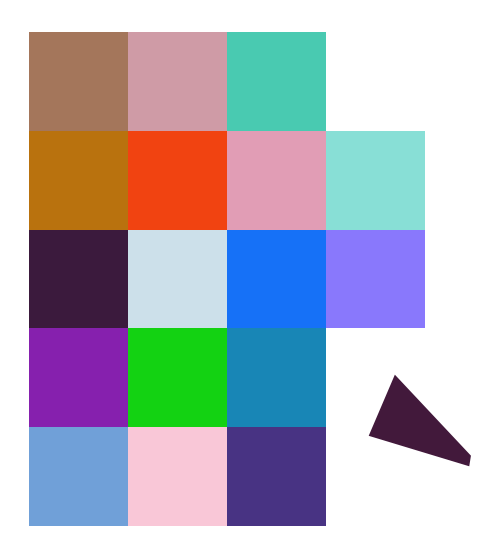

In [20]:
created_geodataframe = read_by_group(ncdf_output_path, 
                                     "test_vector_group")

ax = created_geodataframe.plot(column='TileID', 
                               cmap=cmap, 
                               figsize=(10, 10))
ax.set_axis_off()

In [21]:
created_geodataframe

left       top     right    bottom  TileID  \
1    98900.0  547300.0  188900.0  457300.0  E09N45   
2    98900.0  457300.0  188900.0  367300.0  E09N36   
3    98900.0  367300.0  188900.0  277300.0  E09N27   
4    98900.0  277300.0  188900.0  187300.0  E09N18   
5   188900.0  637300.0  278900.0  547300.0  E18N54   
6   188900.0  547300.0  278900.0  457300.0  E18N45   
7   188900.0  457300.0  278900.0  367300.0  E18N36   
8   188900.0  367300.0  278900.0  277300.0  E18N27   
9   188900.0  277300.0  278900.0  187300.0  E18N18   
10  278900.0  637300.0  368900.0  547300.0  E27N54   
11  278900.0  547300.0  368900.0  457300.0  E27N45   
12  278900.0  457300.0  368900.0  367300.0  E27N36   
13  278900.0  367300.0  368900.0  277300.0  E27N27   
14  278900.0  277300.0  368900.0  187300.0  E27N18   
15  368900.0  547300.0  458900.0  457300.0  E36N45   
16  368900.0  457300.0  458900.0  367300.0  E36N36   
17   98900.0  637300.0  188900.0  547300.0  E09N54   
18       2.0       2.0       2.0       2.0       b   

                                             geometry                  FID  
1   POLYGON ((98900.000 547300.000, 188900.000 547... -9223372036854775806  
2   POLYGON ((98900.000 457300.000, 188900.000 457... -9223372036854775806  
3   POLYGON ((98900.000 367300.000, 188900.000 367... -9223372036854775806  
4   POLYGON ((98900.000 277300.000, 188900.000 277... -9223372036854775806  
5   POLYGON ((188900.000 637300.000, 278900.000 63... -9223372036854775806  
6   POLYGON ((188900.000 547300.000, 278900.000 54... -9223372036854775806  
7   POLYGON ((188900.000 457300.000, 278900.000 45... -9223372036854775806  
8   POLYGON ((188900.000 367300.000, 278900.000 36... -9223372036854775806  
9   POLYGON ((188900.000 277300.000, 278900.000 27... -9223372036854775806  
10  POLYGON ((278900.000 637300.000, 368900.000 63... -9223372036854775806  
11  POLYGON ((278900.000 547300.000, 368900.000 54... -9223372036854775806  
12  POLYGON ((278900.000 457300.000, 368900.000 45...                    2  
13  POLYGON ((278900.000 367300.000, 368900.000 36... -9223372036854775806  
14  POLYGON ((278900.000 277300.000, 368900.000 27... -9223372036854775806  
15  POLYGON ((368900.000 547300.000, 458900.000 54... -9223372036854775806  
16  POLYGON ((368900.000 457300.000, 458900.000 45... -9223372036854775806  
17  POLYGON ((98900.000 637300.000, 188900.000 637...                    1  
18  POLYGON ((431792.698 325173.217, 501062.580 25...                    4

We see that already existing features (12 and 17) were updated, while a new feature was added as well.  
You might ask yourself, why the most left feature of the update-geodataframe was not added.  
When creating a group, the first input defines the dimensions of that group.  
While the centroid of the newly added polygon falls within those dimensions, the centroid of the feature that was not added, does not.

Besides reading an entire group, we can also read by bounds.

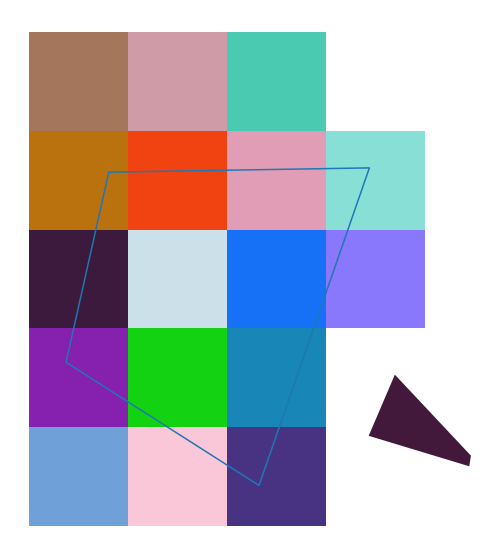

In [22]:
f, ax = plt.subplots(figsize=(10, 10))
created_geodataframe.plot(column='TileID', 
                               cmap=cmap, 
                               figsize=(10, 10),
                               ax=ax)

polygon_as_geodataframe.boundary.plot(ax=ax)
ax.set_axis_off()





created_geodataframe = read_by_bounds(ncdf_output_path, 
                                      Polygon([[171294, 509586],
                                              [408599, 513476],
                                              [308101, 224301],
                                              [132392, 336470]]),
                                     relation_to_bounds="intersects")

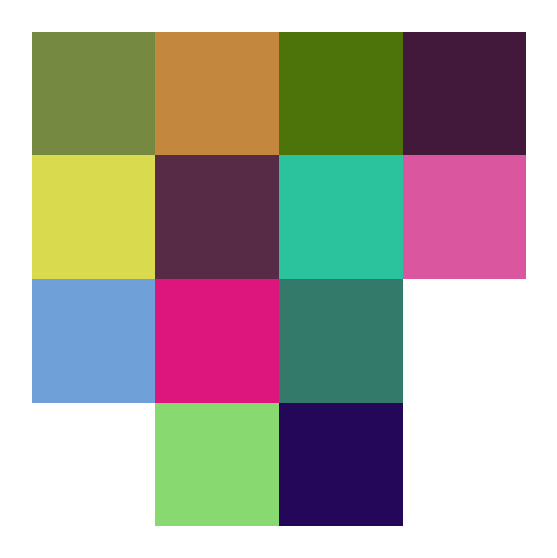

In [23]:
ax = created_geodataframe.plot(column='TileID', 
                               cmap=cmap, 
                               figsize=(10, 10))

ax.set_axis_off()

In [24]:
created_geodataframe

left    bottom  TileID  \
1    98900.0  457300.0  E09N45   
2    98900.0  367300.0  E09N36   
3    98900.0  277300.0  E09N27   
6   188900.0  457300.0  E18N45   
7   188900.0  367300.0  E18N36   
8   188900.0  277300.0  E18N27   
9   188900.0  187300.0  E18N18   
11  278900.0  457300.0  E27N45   
12  278900.0  367300.0  E27N36   
13  278900.0  277300.0  E27N27   
14  278900.0  187300.0  E27N18   
15  368900.0  457300.0  E36N45   
16  368900.0  367300.0  E36N36   

                                             geometry       top     right  \
1   POLYGON ((98900.000 547300.000, 188900.000 547...  547300.0  188900.0   
2   POLYGON ((98900.000 457300.000, 188900.000 457...  457300.0  188900.0   
3   POLYGON ((98900.000 367300.000, 188900.000 367...  367300.0  188900.0   
6   POLYGON ((188900.000 547300.000, 278900.000 54...  547300.0  278900.0   
7   POLYGON ((188900.000 457300.000, 278900.000 45...  457300.0  278900.0   
8   POLYGON ((188900.000 367300.000, 278900.000 36...  367300.0  278900.0   
9   POLYGON ((188900.000 277300.000, 278900.000 27...  277300.0  278900.0   
11  POLYGON ((278900.000 547300.000, 368900.000 54...  547300.0  368900.0   
12  POLYGON ((278900.000 457300.000, 368900.000 45...  457300.0  368900.0   
13  POLYGON ((278900.000 367300.000, 368900.000 36...  367300.0  368900.0   
14  POLYGON ((278900.000 277300.000, 368900.000 27...  277300.0  368900.0   
15  POLYGON ((368900.000 547300.000, 458900.000 54...  547300.0  458900.0   
16  POLYGON ((368900.000 457300.000, 458900.000 45...  457300.0  458900.0   

                    FID  
1  -9223372036854775806  
2  -9223372036854775806  
3  -9223372036854775806  
6  -9223372036854775806  
7  -9223372036854775806  
8  -9223372036854775806  
9  -9223372036854775806  
11 -9223372036854775806  
12                    2  
13 -9223372036854775806  
14 -9223372036854775806  
15 -9223372036854775806  
16 -9223372036854775806

Finally, we can also read all features within a netCDF file that meet certain requirements using a query.  
Note that a geometry cannot be queried. Use ``read_by_bounds`` therefore instead.  
In the following example, we want to read all features, who's attribute "FID" is bigger than 0.

In [25]:
created_geodataframe =  read_by_attribute(ncdf_output_path, 
                                          "FID", 
                                          2,
                                          query='>=')
created_geodataframe

left    bottom  TileID  \
0  278900.0  367300.0  E27N36   
1       2.0       2.0       b   

                                            geometry       top     right  FID  
0  POLYGON ((278900.000 457300.000, 368900.000 45...  457300.0  368900.0    2  
1  POLYGON ((431792.698 325173.217, 501062.580 25...       2.0       2.0    4

## Raster

The other part of the GeoVille Storage Gate handles the reading and writing of raster data.  
Let's read an example raster file first.

In [26]:
import rasterio as rio
import matplotlib.pyplot as plt
from geoville_storage_gate.raster import *

In [27]:
# test variables
with rio.open("/home/schmid/Repos/geoville_ms_storage_gate_modul/tests/data/test_raster.tif") as src:
    array = src.read()
    profile = src.profile

Similar to the vector functions, before the netCDF or the group you want to create exists, we need to create it with ``create_by_group``.

In [28]:
if os.path.exists(ncdf_output_path):
    os.remove(ncdf_output_path)
    
create_by_group(array, 
                profile, 
                ncdf_output_path, 
                "test_raster_group", 
                "2019-05-01",
                "2019-05-01", 
                array_variable="raster")

Let's get the raster and its metadata (geotransform, crs, etc.) by reading the previously created group like follows:

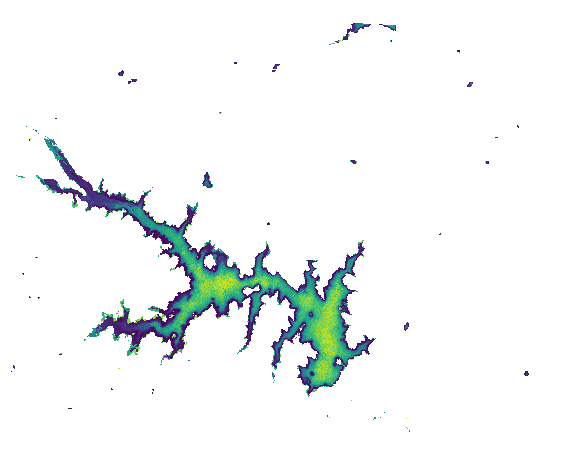

In [29]:
written_array, written_profile = read_by_group(ncdf_output_path, 
                                                  "2019-05-01",
                                                  "2019-05-01", 
                                                  "test_raster_group",
                                                  array_variable="raster")

plt.figure(figsize = (10,10))
plt.imshow(written_array[0])
plt.axis('off')
plt.show()

We can also upsert the group. If the timestamp already exists, the raster will get replaced, otherwise it gets added.  
In the following case, the group contains 2019-05-01 but not 2019-05-02 yet, so the raster will get added.

In [30]:
create_by_group(array, 
                profile, 
                ncdf_output_path, 
                "test_raster_group2", 
                "2019-05-01",
                "2019-05-01", 
                array_variable="raster")

/home/schmid/Repos/geoville_ms_storage_gate_modul/geoville_storage_gate/raster.py:171: RuntimeWarning: /home/schmid/Desktop/vector_example.nc already exists. Please use the function 'upsert_by_group'
  "function 'upsert_by_group'".format(ncdf_path), RuntimeWarning)


In [31]:
upsert_by_group(array, 
                profile, 
                ncdf_output_path, 
                "test_raster_group", 
                "2019-05-02",
                "2019-05-02", 
                array_variable="raster")

Now we can read both dates and get a 2-layer result.

(2, 1325, 1683)


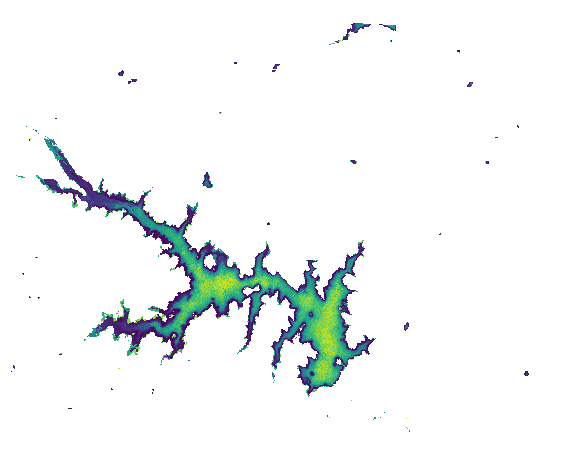

In [32]:
written_array, written_profile = read_by_group(ncdf_output_path, 
                                                  "2019-05-01", 
                                                  "2019-05-02", 
                                                  "test_raster_group",
                                                  array_variable="raster")

print(written_array.shape)

plt.figure(figsize = (10,10))
plt.imshow(written_array[0])
plt.axis('off')
plt.show()

Now we update the first layer, the product of the date 2019-05-01, but only within given bounds.  

In [33]:
update_by_bounds((array * 0) + 99,
                 profile,
                 ncdf_output_path,
                 Polygon([[661697.166128716, 4320223.863762978],
                          [660697.2823883237, 4320130.124662316],
                          [660603.5432876621, 4321296.655692774],
                          [661738.8279512323, 4321234.162958999],
                          [661697.166128716, 4320223.863762978]]),
                 "2019-05-01",
                 "2019-05-01",
                 array_variable="raster")

Let's read the entire group at date 2019-05-01 and see if we can see the updated patch with 99 values.

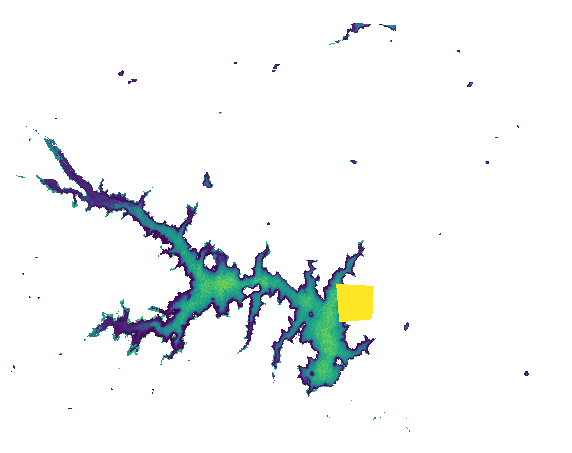

In [34]:
written_array, written_profile = read_by_group(ncdf_output_path, 
                                                  "2019-05-01", 
                                                  "2019-05-01", 
                                                  "test_raster_group",
                                                  array_variable="raster")

with rio.open("/home/schmid/Desktop/testraster.tif", "w", **written_profile) as dst:
    dst.write(written_array[0], 1)


plt.figure(figsize = (10,10))
plt.imshow(written_array[0])
plt.axis('off')
plt.show()

Moreover, we can also just read the raster of a specific date within the given bounds.

/home/schmid/Repos/geoville_ms_storage_gate_modul/geoville_storage_gate/raster.py:134: RuntimeWarning: All-NaN axis encountered
  ncdf_array = np.nanmax(ncdf_arrays, axis=0)


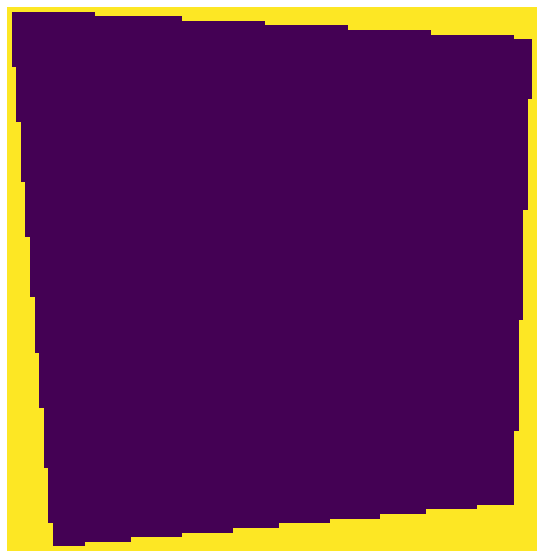

In [35]:
updated_array, updated_profile = read_by_bounds(
                                      ncdf_output_path,
                                      "2019-05-01",
                                      "2019-05-01",
                                      Polygon([[661697.166128716, 4320223.863762978],
                                              [660697.2823883237, 4320130.124662316],
                                              [660603.5432876621, 4321296.655692774],
                                              [661738.8279512323, 4321234.162958999],
                                              [661697.166128716, 4320223.863762978]]),
                                      array_variable="raster")


plt.figure(figsize = (10,10))
plt.imshow(updated_array[0])
plt.axis('off')
plt.show()